# 03_anchor_generator
**This file used to generate anchors for UECFOOD100 dataset through kmeans.
Distance here is not Euclidean distance but IoU (Intersection over Union) in
accordance with original yolo-v2 paper.**

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np

**k-means clustering**:  
- Input: k, set of points [w1,h1], [w2,h2], [w3, h3], ..., [wn, hn] 
- Place centroids c1, ..., ck at random locations (randomly select k [w,h] among input img wh)
- Repeat until convergence:
    - for each point [wi,hi]:
        - find nearest centroid cj. (np.argmin(new_distances, axis=1))
        - assign the point [wi,hi] to cluster j.
    - for each cluster j=1, ...,k: (update centroids)
        - new centroid cj=mean of all points [wi,hi] assigned to cluster j in previous step
        $\frac{1}{n_j}\sum\limits_{x_i\rightarrow c_j}x_i(a)$  (a means a particular attribute in this case a is wh[i])
- Stop when none of the cluster assignments change

In [2]:
def kmeans(wh, centroids, anchor_txt):
    num = wh.shape[0]  # total number of different wh pairs
    k, dim = centroids.shape
    iter = 0
    old_distances = np.zeros((num, k))
    _assignments = -np.ones(num)

    # iterate until
    while True:
        new_distances = []
        iter += 1
        for i in range(num):
            distance = 1 - IoU(wh[i], centroids)  # high IoU represents low distance
            new_distances.append(distance)
        new_distances = np.array(new_distances)
        print('Iter {}: distances: {}'.format(iter, np.sum((np.abs(old_distances - new_distances)))))

        # for each input img assign a centroid (select the closed one)
        assignments = np.argmin(new_distances, axis=1)
        if (assignments == _assignments).all():
            print('final centroids =', centroids)
            save_anchors(centroids, anchor_txt, wh_in_mobilenet)
            return centroids
        else:
            centroid_sums = np.zeros((k, dim), np.float)
            for i in range(num):
                centroid_sums[assignments[i]] += wh[i]  # sum up attribute
            for j in range(k):
                # new centroids
                centroids[j] = centroid_sums[j] / np.sum(assignments == j)

            _assignments = assignments.copy()
            old_distances = new_distances.copy()

In [3]:
def save_anchors(centroids, anchor_txt, wh_in_mobilenet):
    width_in_yolov2 = wh_in_mobilenet[0]
    height_in_yolov2 = wh_in_mobilenet[1]
    with open(anchor_txt, 'w') as file:
        anchors = centroids.copy()
        for i in range(anchors.shape[0]):
            anchors[i][0] *= width_in_yolov2 / 32.
            anchors[i][1] *= height_in_yolov2 / 32.
        widths = anchors[:, 0]
        sorted_indices = np.argsort(widths)  # return the indices that sort tht array
        print('anchors = ', anchors[sorted_indices])

        for i in sorted_indices:
            file.write('%0.2f, %0.2f\n' % (anchors[i, 0], anchors[i, 1]))

In [4]:
def avgIoU(wh, centroids):
    sum = 0.
    for i in range(wh.shape[0]):
        sum += max(IoU(wh[i], centroids))
    return sum / wh.shape[0]

**IoU - Intersection over Union **

In [5]:
def IoU(whi, centroids):
    """ Calculate IoU between current centroids with one in wh array to check if current
    centroids are suitable enough
    :param whi:
    :param centroids:
    :return:
    """
    IOU = []
    for centroid in centroids:
        c_w, c_h = centroid
        w, h = whi
        if c_w >= w and c_h >= h:
            iou = w * h / (c_w * c_h)
        elif c_w >= w and c_h <= h:
            iou = w * c_h / (w * h + (c_w - w) * c_h)
        elif c_w <= w and c_h >= h:
            iou = c_w * h / (w * h + (c_h - h) * c_w)
        else:
            iou = c_w * c_h / (w * h)
        IOU.append(iou)
    return np.array(IOU)

In [6]:
def coordinate2wh(coordinates, shape):
    coordinates = list(map(float, coordinates))
    w = (coordinates[2] - coordinates[0]) / shape[0] # x2-x1
    h = (coordinates[3] - coordinates[1]) / shape[1] # y2-y1
    return w, h

In [13]:
def gen_anchors(n_clusters):
#     dataset_disk = '/Volumes/JS/UECFOOD100_448/'
#     dataset_disk = '/Volumes/JS/UECFOOD256/UECFOOD256/'
    output_path = './'
    train_uec100 = './food_boxes.txt'

    if not os.path.exists(output_path):
        os.mkdir(output_path)

    wh = []

    with open(train_uec100, 'r') as file:
        for i, line in enumerate(file):
            line = line.rstrip('\n')[1:-1]
            line = line.split(' ')
            coordinates = [int(x) for x in line]
            w, h = coordinate2wh(coordinates, shape=[224, 224])
            wh.append([w, h])
        wh = np.array(wh)

        if n_clusters == 0:  # make from 1 to 10 clusters and pick the best one
            avgIou = []
            for n_cluster in range(1, 11):
                anchor_txt = os.path.join(output_path, 'anchors_%d.txt' % (n_cluster))
                # randomly select n_cluster anchors from wh array which contain w,h for each img
                indices = [random.randrange(wh.shape[0]) for i in range(n_cluster)]
                centroids = wh[indices]
                centroids = kmeans(wh, centroids, anchor_txt)
                avgIou.append([n_cluster, avgIoU(wh, centroids)])
            avgIou = np.array(avgIou)
            plt.plot(avgIou[:, 0], avgIou[:, 1])
            plt.scatter(avgIou[:, 0], avgIou[:, 1], c='r')
            plt.xlabel('number of cluster')
            plt.ylabel('average IoU')
            plt.savefig('avg_iou')
            plt.show()
        else:
            anchor_txt = os.path.join(output_path, 'anchors_%d.txt' % (n_clusters))
            # randomly select n_cluster anchors from wh array which contain w,h for each img
            indices = [random.randrange(wh.shape[0]) for i in range(n_clusters)]
            centroids = wh[indices]
            kmeans(wh, centroids, anchor_txt)

        print('Done!')

In [14]:
wh_in_mobilenet = [224, 224]
# uec256_dims = [800, 600]  # dataset image width=800, height=600
n_clusters = 0

Iter 1: distances: 72.42294013232066
Iter 2: distances: 35.0232620636886
final centroids = [[0.36230092 0.37644788]]
anchors =  [[2.53610642 2.63513514]]
Iter 1: distances: 153.32749851880968
Iter 2: distances: 26.79165512482817
Iter 3: distances: 10.944577219103317
Iter 4: distances: 5.624035404445913
Iter 5: distances: 1.2281195281039148
Iter 6: distances: 1.2283192280572401
Iter 7: distances: 2.1865448204828555
Iter 8: distances: 1.2042375985141451
Iter 9: distances: 1.0855263090726943
Iter 10: distances: 4.261786454958634
Iter 11: distances: 3.182405436298642
Iter 12: distances: 2.1737884399199023
Iter 13: distances: 1.095966406536481
Iter 14: distances: 1.08583901549071
Iter 15: distances: 1.1242744243669667
final centroids = [[0.49759615 0.51737637]
 [0.25634682 0.26608219]]
anchors =  [[1.79442771 1.8625753 ]
 [3.48317308 3.62163462]]
Iter 1: distances: 280.3025823579848
Iter 2: distances: 29.51991660816268
Iter 3: distances: 18.664834363405557
Iter 4: distances: 16.394853554980

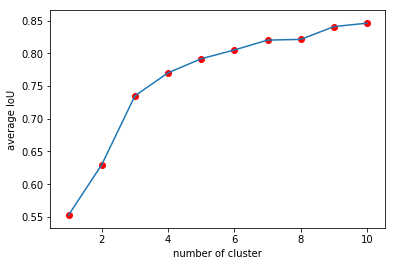

Done!


In [15]:
gen_anchors(n_clusters)

In [ ]:
train_uec100 = '/Users/jianingsun/Documents/Research/Nov/mask_food/example/food/food_boxes.txt'
with open(train_uec100, 'r') as file:
    for i, line in enumerate(file):
        line = line.rstrip('\n')[1:-1]
        line = line.split(' ')
        coordinates = [int(x) for x in line]
        print(coordinates)